In [ ]:
%pip install bertopic

In [2]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import string

from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic

import matplotlib.pyplot as plt
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Setup e Pre-processing

## Download Dataset

In [3]:
df = pd.read_csv("data.csv")
df["date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["class"] = df["toxicity"].apply(lambda t: "Hate" if t > 0.5 else "Non-Hate")

df = df[df["class"] == "Hate"]
texts_list= list(df["comment_text"])

In [4]:
# @title Creazione degli Embeddings
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = model.encode(texts_list, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/715 [00:00<?, ?it/s]

## Dimensionality Reduction

In [5]:
from sklearn.decomposition import PCA

# Denoising embedding trough PCA
pca = PCA(n_components=50, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

#umap_model = UMAP(n_components=5, min_dist=0.0, metric="cosine", random_state=42)
umap_model = UMAP(
    n_neighbors=50, # Default is 15, maube this could also go up
    n_components=15,  # Same
    metric="cosine",
    min_dist=0.0,
    random_state=42
)

# Topic Modeling con BERTTopic

## Rimozione delle stopwords dagi articoli


In [6]:
# Nel calcoo degli embedding contestuali rimuovere le stopwords non da alcun vantaggio, anzi potrebbe peggiorare le performance.
# Tuttavia BERTTopic utilizza internamente una variante di TF-IDF ragion per cui utilizziamo gli embeddings generati dal testo originale ma passiamo il testo "pulito" al modello
# N.B. Senza questo accorgimento il modello fa molta fatica ed individua solo 2 topics con rappresentati tutte stopword

stop_words = set(stopwords.words("english"))
processed_texts = [None] * texts_list.__len__()

for i in range(texts_list.__len__()):
    # Remove stop words
    processed_texts[i] = " ".join([word for word in word_tokenize(texts_list[i]) if word.lower() not in stop_words and word not in string.punctuation])

## Istanziazione del modello e creazione dei topic

In [11]:
#min_samples should reduce some noise
hdbscan_model = HDBSCAN(min_cluster_size=150, metric="euclidean",cluster_selection_method="eom").fit(reduced_embeddings)
topic_model = BERTopic(embedding_model = model, umap_model = umap_model, hdbscan_model = hdbscan_model, verbose=True).fit(processed_texts, embeddings)

2025-09-25 03:28:00,726 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-25 03:29:10,213 - BERTopic - Dimensionality - Completed ✓
2025-09-25 03:29:10,216 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-25 03:29:13,202 - BERTopic - Cluster - Completed ✓
2025-09-25 03:29:13,211 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-25 03:29:13,649 - BERTopic - Representation - Completed ✓


In [12]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11453,-1_trump_like_stupid_people,"[trump, like, stupid, people, get, would, one,...",[`` Well ca n't see '' See dumb watch one gove...
1,0,1613,0_trump_president_obama_putin,"[trump, president, obama, putin, russian, russ...",[Trump 's stupid investigation looking Hillary...
2,1,1468,1_stupid_comment_troll_re,"[stupid, comment, troll, re, dumb, idiot, comm...","[stupid, stupid, Stupid comment]"
3,2,1459,2_canada_trudeau_canadians_canadian,"[canada, trudeau, canadians, canadian, justin,...",[left wingers thier nature stupid full hate si...
4,3,1338,3_racist_white_black_people,"[racist, white, black, people, blacks, racism,...","[racist, Racist, `` white trash '' Wow black s..."
5,4,1093,4_gun_guns_people_shoot,"[gun, guns, people, shoot, kill, like, stupid,...",[Totally opposite learning facility stands exc...
6,5,743,5_hillary_clinton_woman_would,"[hillary, clinton, woman, would, trump, liar, ...","[Hillary liar needs said know liar always lie,..."
7,6,687,6_tax_climate_taxes_pay,"[tax, climate, taxes, pay, money, people, stup...",[flip talking ItsMe Income tax deductions base...
8,7,486,7_left_wing_liberal_liberals,"[left, wing, liberal, liberals, hate, ignorant...","[typical left wing bs usual loser .., aaa anot..."
9,8,463,8_muslims_muslim_islam_terrorist,"[muslims, muslim, islam, terrorist, islamic, t...","[Muslims must really hate Muslims, Time get ri..."


## Cluster analysis

In [13]:
topic_model.visualize_topics()

In [14]:
topics_over_time = topic_model.topics_over_time(texts_list, list(df["date"]))
topic_model.visualize_topics_over_time(topics_over_time)

2025-09-25 03:31:13,738 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 22868) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
22868it [11:25, 33.36it/s]


In [15]:
fig = topic_model.visualize_documents(
  texts_list,
  reduced_embeddings = reduced_embeddings,
  width = 1200,
  hide_annotations = False
)
fig.update_layout(font = dict(size = 16))
topic_model.visualize_barchart()

In [34]:
df["month"] = df["date"].dt.year.astype(str) + "-" + df["date"].dt.month.astype(str)
df["topic"] = topic_model.topics_.


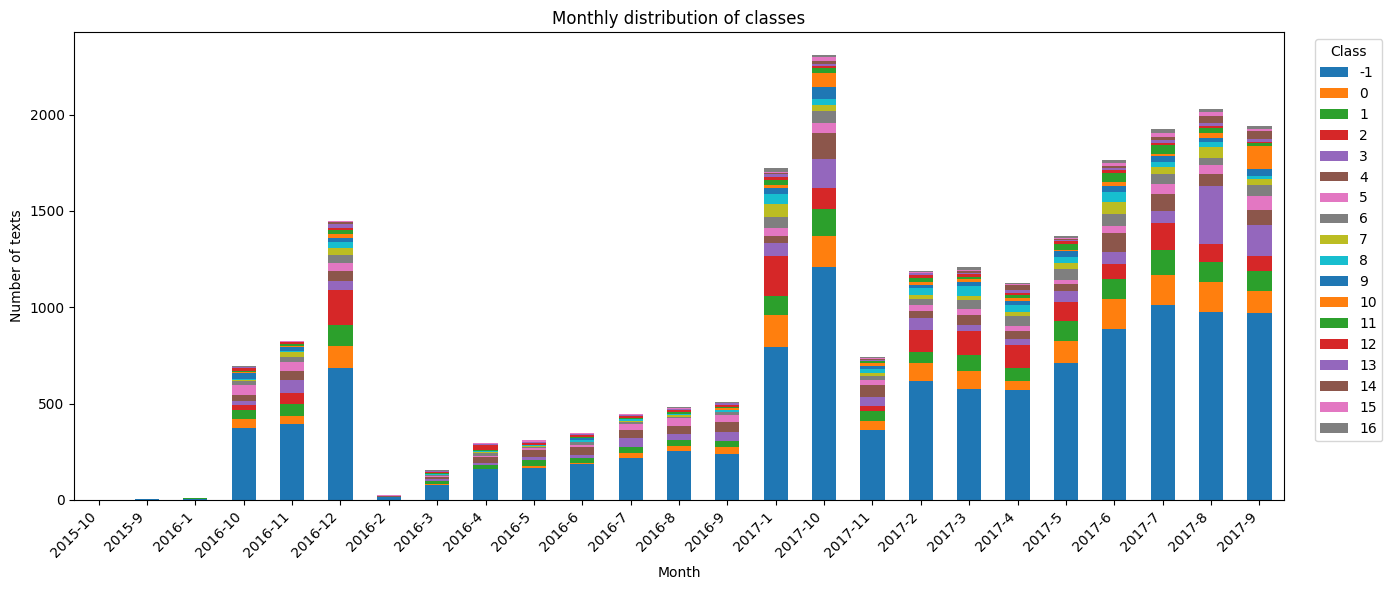

In [36]:
import matplotlib.pyplot as plt

monthly_counts = df.groupby(["month", "topic"]).size().unstack(fill_value=0).sort_index()
monthly_counts.plot(kind="bar", stacked=True, figsize=(14, 6))

plt.title("Monthly distribution of classes")
plt.xlabel("Month")
plt.ylabel("Number of texts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
topic_model.visualize_heatmap(n_clusters = 2)